In [1]:
from typing import Iterator, List, Union, Tuple, Any
from datetime import datetime

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, Model
from tensorflow.python.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from tensorflow.keras.losses import MeanAbsoluteError, MeanAbsolutePercentageError
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import History

### Useful Links
- https://rosenfelder.ai/keras-regression-efficient-net/
- https://github.com/MarkusRosen/keras-efficientnet-regression
- https://towardsdatascience.com/image-classification-transfer-learning-and-fine-tuning-using-tensorflow-a791baf9dbf3
- https://pyimagesearch.com/2019/05/27/keras-feature-extraction-on-large-datasets-with-deep-learning/

# Data Collection

### Data Source: https://www.kaggle.com/c/bone-age-regression/data

In [2]:
df = pd.read_csv('data/train.csv')
df = df.sort_values(by='fileName')[:500]
df

,fileName,boneage,male
3957,10000.png,96,True
10831,10001.png,168,True
132,10002.png,168,True
3494,10003.png,76,False
9580,10004.png,135,True
...,...,...,...
2765,10616.png,168,True
7257,10617.png,168,False
4653,10618.png,69,False
6540,10621.png,78,True


In [9]:
# ENDED UP NOT USED

df_pred = pd.read_csv('data/test.csv')
df_pred_sorted = df_pred.sort_values('fileName')[:50]
df_pred_sorted

,fileName,male
852,10007.png,True
1220,10017.png,False
463,10019.png,True
824,10030.png,False
999,10037.png,False
319,10059.png,True
809,10069.png,False
482,10108.png,True
1192,10120.png,True
1254,10132.png,False


# Data Preprocessing

### Credit: - https://github.com/MarkusRosen/keras-efficientnet-regression

In [3]:
def split_data(df: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """Accepts a Pandas DataFrame and splits it into training, testing and validation data. Returns DataFrames.
    Parameters
    ----------
    df : pd.DataFrame
        Your Pandas DataFrame containing all your data.
    Returns
    -------
    Union[pd.DataFrame, pd.DataFrame, pd.DataFrame]
        [description]
    """
    train, val = train_test_split(df, test_size=0.2, random_state=1)  # split the data with a validation size o 20%
    train, test = train_test_split(
        train, test_size=0.125, random_state=1
    )  # split the data with an overall  test size of 10%

    print("shape train: ", train.shape)
    print("shape val: ", val.shape)
    print("shape test: ", test.shape)

    print("Descriptive statistics of train:")
    print(train.describe())
    return train, val, test

In [4]:
train, val, test = split_data(df)
train.head()

shape train:  (350, 3)
shape val:  (100, 3)
shape test:  (50, 3)
Descriptive statistics of train:
          boneage
count  350.000000
mean   124.971429
std     41.420885
min     10.000000
25%     94.000000
50%    132.000000
75%    156.000000
max    228.000000


,fileName,boneage,male
10961,10322.png,162,True
10259,10562.png,150,True
9339,10271.png,54,True
10520,10051.png,150,True
3584,10228.png,168,True


In [5]:
def create_generators(train: pd.DataFrame, val: pd.DataFrame, test: pd.DataFrame) -> Tuple[Iterator, Iterator, Iterator]:
    """Accepts four Pandas DataFrames: all your data, the training, validation and test DataFrames. Creates and returns
    keras ImageDataGenerators. Within this function you can also visualize the augmentations of the ImageDataGenerators.
    Parameters
    ----------
    df : pd.DataFrame
        Your Pandas DataFrame containing all your data.
    train : pd.DataFrame
        Your Pandas DataFrame containing your training data.
    val : pd.DataFrame
        Your Pandas DataFrame containing your validation data.
    test : pd.DataFrame
        Your Pandas DataFrame containing your testing data.
    Returns
    -------
    Tuple[Iterator, Iterator, Iterator]
        keras ImageDataGenerators used for training, validating and testing of your models.
    """
    train_generator = ImageDataGenerator(
        rescale=1.0 / 255,
#         rotation_range=5,
#         width_shift_range=0.1,
#         height_shift_range=0.1,
#         brightness_range=(0.75, 1),
#         shear_range=0.1,
#         zoom_range=[0.75, 1],
#         horizontal_flip=True,
#         validation_split=0.2,
    )  # create an ImageDataGenerator with multiple image augmentations
    validation_generator = ImageDataGenerator(rescale=1.0 / 255)
    test_generator = ImageDataGenerator(rescale=1.0 / 255)
    
    directory = './data/img'

    train_generator = train_generator.flow_from_dataframe(
        dataframe=train,
        directory=directory,
        x_col="fileName",  # this is where your image data is stored
        y_col="boneage",  # this is your target feature
        class_mode="raw",  # use "raw" for regressions
        target_size=(224, 224),
#         batch_size=32,  # increase or decrease to fit your GPU
#         validate_filenames=False
    )
    
    validation_generator = validation_generator.flow_from_dataframe(
        dataframe=val, 
        directory=directory,
        x_col="fileName", 
        y_col="boneage", 
        class_mode="raw", 
        target_size=(224, 224), 
#         batch_size=128,
#         validate_filenames=False
    )
    
    test_generator = test_generator.flow_from_dataframe(
        dataframe=test, 
        directory=directory,
        x_col="fileName",
        y_col="boneage", 
        class_mode="raw",
        target_size=(224, 224),
#         batch_size=128,
#         validate_filenames=False,
    )
    
    return train_generator, validation_generator, test_generator

In [6]:
train_generator, validation_generator, test_generator = create_generators(train, val, test)

Found 350 validated image filenames.
Found 100 validated image filenames.
Found 50 validated image filenames.


# Modeling

In [8]:
def bone_cnn() -> Sequential:
    """A very small custom convolutional neural network with image input dimensions of 224x224x3.
    Returns
    -------
    Sequential
        The keras Sequential model.
    """
    model = models.Sequential()
    model.add(layers.Conv2D(128, (3, 3), activation="relu", input_shape=(224, 224, 3)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(256, (3, 3), activation="relu"))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(256, (3, 3), activation="relu"))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation="relu"))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation="relu"))
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation="relu"))
    model.add(layers.Dense(64, activation="relu"))
    model.add(layers.Dense(64, activation="relu"))
    model.add(layers.Dense(1))

    return model

In [180]:
model = bone_cnn()
model.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_64 (Conv2D)          (None, 222, 222, 128)     3584      
                                                                 
 max_pooling2d_60 (MaxPoolin  (None, 111, 111, 128)    0         
 g2D)                                                            
                                                                 
 conv2d_65 (Conv2D)          (None, 109, 109, 256)     295168    
                                                                 
 max_pooling2d_61 (MaxPoolin  (None, 54, 54, 256)      0         
 g2D)                                                            
                                                                 
 conv2d_66 (Conv2D)          (None, 52, 52, 256)       590080    
                                                                 
 max_pooling2d_62 (MaxPoolin  (None, 26, 26, 256)    

In [181]:
model.compile(loss='mean_absolute_error', metrics=[MeanAbsoluteError()])

## First 50 Epochs

In [182]:
hist = model.fit(
    train_generator, 
    epochs=50, 
    validation_data=validation_generator, 
#     callbacks=callbacks,
    workers=4
)

Epoch 1/50
5/5 [==============================] - 200s 45s/step - loss: 473.1548 - mean_absolute_error: 428.8510 - val_loss: 91.7125 - val_mean_absolute_error: 88.9710
Epoch 2/50
5/5 [==============================] - 232s 47s/step - loss: 64.5656 - mean_absolute_error: 64.0311 - val_loss: 48.5661 - val_mean_absolute_error: 40.3580
Epoch 3/50
5/5 [==============================] - 166s 32s/step - loss: 41.3116 - mean_absolute_error: 41.3506 - val_loss: 42.9595 - val_mean_absolute_error: 41.1458
Epoch 4/50
5/5 [==============================] - 166s 33s/step - loss: 45.1148 - mean_absolute_error: 47.3927 - val_loss: 42.9687 - val_mean_absolute_error: 40.9678
Epoch 5/50
5/5 [==============================] - 165s 32s/step - loss: 57.1699 - mean_absolute_error: 55.4068 - val_loss: 42.4949 - val_mean_absolute_error: 43.6454
Epoch 6/50
5/5 [==============================] - 164s 32s/step - loss: 54.5439 - mean_absolute_error: 55.2958 - val_loss: 91.1721 - val_mean_absolute_error: 93.4844
Ep

## 70 Epochs (50 + 20)

In [187]:
hist_70 = model.fit(
    train_generator, 
    epochs=20, 
    validation_data=validation_generator, 
#     callbacks=callbacks,
    workers=4
)

Epoch 1/20
5/5 [==============================] - 212s 49s/step - loss: 38.1142 - mean_absolute_error: 37.8270 - val_loss: 40.2223 - val_mean_absolute_error: 35.5536
Epoch 2/20
5/5 [==============================] - 184s 37s/step - loss: 42.8524 - mean_absolute_error: 45.9788 - val_loss: 54.0397 - val_mean_absolute_error: 52.4850
Epoch 3/20
5/5 [==============================] - 193s 44s/step - loss: 52.1763 - mean_absolute_error: 53.4075 - val_loss: 68.9681 - val_mean_absolute_error: 70.4049
Epoch 4/20
5/5 [==============================] - 194s 39s/step - loss: 47.3948 - mean_absolute_error: 45.1616 - val_loss: 30.7590 - val_mean_absolute_error: 25.6100
Epoch 5/20
5/5 [==============================] - 186s 38s/step - loss: 48.3551 - mean_absolute_error: 47.4300 - val_loss: 31.2535 - val_mean_absolute_error: 34.7706
Epoch 6/20
5/5 [==============================] - 167s 33s/step - loss: 36.4899 - mean_absolute_error: 36.6196 - val_loss: 51.8049 - val_mean_absolute_error: 51.6381
Epoc

## 90 Epochs (50 + 20 + 20)

In [195]:
hist_90 = model.fit(
    train_generator, 
    epochs=20, 
    validation_data=validation_generator, 
#     callbacks=callbacks,
    workers=4
)

Epoch 1/20
5/5 [==============================] - 172s 33s/step - loss: 37.8656 - mean_absolute_error: 37.1810 - val_loss: 29.0611 - val_mean_absolute_error: 24.1985
Epoch 2/20
5/5 [==============================] - 179s 36s/step - loss: 42.1499 - mean_absolute_error: 40.8258 - val_loss: 27.9815 - val_mean_absolute_error: 27.5409
Epoch 3/20
5/5 [==============================] - 180s 41s/step - loss: 40.1521 - mean_absolute_error: 38.8630 - val_loss: 28.2397 - val_mean_absolute_error: 28.7537
Epoch 4/20
5/5 [==============================] - 216s 42s/step - loss: 50.4977 - mean_absolute_error: 48.2911 - val_loss: 30.7421 - val_mean_absolute_error: 29.4113
Epoch 5/20
5/5 [==============================] - 200s 39s/step - loss: 37.5126 - mean_absolute_error: 35.7336 - val_loss: 27.1947 - val_mean_absolute_error: 24.4773
Epoch 6/20
5/5 [==============================] - 201s 39s/step - loss: 39.0722 - mean_absolute_error: 38.7654 - val_loss: 27.9934 - val_mean_absolute_error: 29.9467
Epoc

### 90 Epochs Result

In [196]:
model.evaluate(test_generator)

1/1 [==============================] - 7s 7s/step - loss: 32.7033 - mean_absolute_error: 32.7033


[32.70326232910156, 32.70326232910156]

## 150 Epochs (50 + 20 + 20 + 60)
Continued from yesterday's training

In [12]:
## Continue Training for Tomorrow (5/3/2022)

model = load_model('model/model_medium_90_epochs.h5', compile=False)
model.compile(loss='mean_absolute_error', metrics=[MeanAbsoluteError()])

In [13]:
hist_150 = model.fit(
    train_generator, 
    epochs=60, 
    validation_data=validation_generator, 
#     callbacks=callbacks,
    workers=3
)

Epoch 1/60
5/5 [==============================] - 173s 33s/step - loss: 83.5851 - mean_absolute_error: 77.2875 - val_loss: 28.9512 - val_mean_absolute_error: 32.0961
Epoch 2/60
5/5 [==============================] - 193s 36s/step - loss: 36.4306 - mean_absolute_error: 34.9081 - val_loss: 35.8249 - val_mean_absolute_error: 36.6276
Epoch 3/60
5/5 [==============================] - 193s 37s/step - loss: 28.0266 - mean_absolute_error: 26.5719 - val_loss: 45.8072 - val_mean_absolute_error: 42.5839
Epoch 4/60
5/5 [==============================] - 184s 35s/step - loss: 47.9675 - mean_absolute_error: 46.6652 - val_loss: 48.6700 - val_mean_absolute_error: 46.3137
Epoch 5/60
5/5 [==============================] - 187s 37s/step - loss: 37.9036 - mean_absolute_error: 37.7426 - val_loss: 43.2055 - val_mean_absolute_error: 46.1213
Epoch 6/60
5/5 [==============================] - 206s 42s/step - loss: 37.2198 - mean_absolute_error: 37.5666 - val_loss: 46.8658 - val_mean_absolute_error: 40.5528
Epoc

### 150 Epochs Result

In [14]:
model.evaluate(test_generator)

1/1 [==============================] - 7s 7s/step - loss: 21.2716 - mean_absolute_error: 21.2716


[21.271625518798828, 21.271625518798828]

### Save 150 Epochs Trained Medium Model

In [16]:
model.save("model/model_medium_150_epochs.h5")
print("Saved model to disk")

Saved model to disk


### Visualize 150 Epochs History

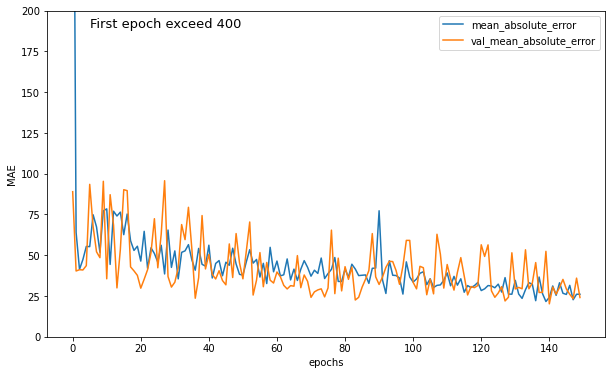

In [69]:
data = pd.read_csv('model/medium_cnn_150_epochs_history.csv')

plt.figure(figsize=(10, 6))
# data['loss'][1:].plot()
# data['val_loss'][1:].plot()
data['mean_absolute_error'][:].plot()
data['val_mean_absolute_error'][:].plot()
plt.legend(['mean_absolute_error', 'val_mean_absolute_error'])
plt.gca().set_ylim([0, 200])
plt.annotate('First epoch exceed 400',
             xy=(5, 190), 
             size=13)
plt.xlabel("epochs")
plt.ylabel("MAE")
plt.show()

# Transfer Learning
- https://www.analyticsvidhya.com/blog/2017/06/transfer-learning-the-art-of-fine-tuning-a-pre-trained-model/
- https://machinelearningmastery.com/how-to-use-transfer-learning-when-developing-convolutional-neural-network-models/
- https://stackoverflow.com/questions/41378461/how-to-use-models-from-keras-applications-for-transfer-learnig/41386444#41386444
- https://github.com/keras-team/keras/issues/890 (splitting layers)

In [10]:
medium_model = load_model('model/model_medium_150_epochs.h5', compile=False)

for layer in medium_model.layers:
    layer.trainable = False

# CNN layers + Flatten Layer is until 11-th layer
cnn_layer = Model(inputs=medium_model.inputs, outputs=medium_model.layers[10].output) 

def model_build(cnn, gender=True):
    assert type(gender) == bool
    if gender:
        network_input_shape = (cnn.output[0].shape[0]+1, )
    else:
        network_input_shape = cnn.output[0].shape
    print(network_input_shape)
    
    inputs = keras.layers.Input(shape=network_input_shape)
    x = keras.layers.Dense(2048, activation='relu')(inputs)
    x = keras.layers.Dense(2048, activation='relu')(x)
#     x = keras.layers.Dense(2048, activation='relu')(x)
    out = keras.layers.Dense(1)(x)
    
    model_name = 'gender-based-model' if gender else 'non-gender-based-model'
    model = Model(inputs=inputs, outputs=out, name=model_name)
        
    return model

### Feature Extraction

In [11]:
X_train_vectors = cnn_layer.predict(train_generator)
X_validation_vectors = cnn_layer.predict(validation_generator)
X_test_vectors = cnn_layer.predict(test_generator)

In [12]:
print(X_train_vectors.shape)
print(X_validation_vectors.shape)
print(X_test_vectors.shape)

(350, 1600)
(100, 1600)
(50, 1600)


In [13]:
Y_train_vectors = train_generator.labels
Y_validation_vectors = validation_generator.labels
Y_test_vectors = test_generator.labels

In [14]:
print(Y_train_vectors.shape)
print(Y_validation_vectors.shape)
print(Y_test_vectors.shape)

(350,)
(100,)
(50,)


### Gender Variable Processing

In [15]:
def process_gender_vectors(df, generator, X_vectors):
    gender_value_vector = []

    for fileName in generator.filenames:
        male = df.loc[df['fileName'] == fileName]['male']
        if bool(male.item()):
            gender_value_vector.append(1)
        else:
            gender_value_vector.append(0)
    
    gender_value_vector = np.expand_dims(gender_value_vector, axis=1)
    X_new_vectors = np.append(X_vectors, gender_value_vector, axis=1)
    
    return X_new_vectors

In [16]:
X_new_train_vectors = process_gender_vectors(df, train_generator, X_train_vectors)
X_new_validation_vectors = process_gender_vectors(df, validation_generator, X_validation_vectors)
X_new_test_vectors = process_gender_vectors(df, test_generator, X_test_vectors)

print(X_new_train_vectors.shape)
print(X_new_validation_vectors.shape)
print(X_new_test_vectors.shape)

(350, 1601)
(100, 1601)
(50, 1601)


### Fitting Without Gender

In [17]:
model_wg = model_build(cnn_layer, gender=False)
model_wg.summary()
model_wg.compile(loss='mean_absolute_error', metrics=[MeanAbsoluteError()])

(1600,)
Model: "non-gender-based-model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1600)]            0         
                                                                 
 dense (Dense)               (None, 2048)              3278848   
                                                                 
 dense_1 (Dense)             (None, 2048)              4196352   
                                                                 
 dense_2 (Dense)             (None, 1)                 2049      
                                                                 
Total params: 7,477,249
Trainable params: 7,477,249
Non-trainable params: 0
_________________________________________________________________


In [18]:
hist_wg = model_wg.fit(
    X_train_vectors,
    Y_train_vectors,
    epochs=200, 
    validation_data=(X_validation_vectors, Y_validation_vectors)
)

Epoch 1/200
11/11 [==============================] - 3s 170ms/step - loss: 187.5220 - mean_absolute_error: 186.6327 - val_loss: 42.9944 - val_mean_absolute_error: 51.8784
Epoch 2/200
11/11 [==============================] - 2s 144ms/step - loss: 47.2911 - mean_absolute_error: 47.3095 - val_loss: 64.1792 - val_mean_absolute_error: 75.7339
Epoch 3/200
11/11 [==============================] - 2s 144ms/step - loss: 47.8212 - mean_absolute_error: 47.7113 - val_loss: 37.4638 - val_mean_absolute_error: 43.1552
Epoch 4/200
11/11 [==============================] - 2s 144ms/step - loss: 38.8798 - mean_absolute_error: 38.8243 - val_loss: 49.8730 - val_mean_absolute_error: 61.0001
Epoch 5/200
11/11 [==============================] - 2s 139ms/step - loss: 45.4104 - mean_absolute_error: 45.4720 - val_loss: 43.4329 - val_mean_absolute_error: 42.1027
Epoch 6/200
11/11 [==============================] - 2s 140ms/step - loss: 39.7697 - mean_absolute_error: 39.7256 - val_loss: 38.5484 - val_mean_absolute

11/11 [==============================] - 2s 204ms/step - loss: 30.9124 - mean_absolute_error: 30.9029 - val_loss: 41.9364 - val_mean_absolute_error: 48.8956
Epoch 50/200
11/11 [==============================] - 2s 184ms/step - loss: 28.7057 - mean_absolute_error: 28.6660 - val_loss: 41.4099 - val_mean_absolute_error: 48.2292
Epoch 51/200
11/11 [==============================] - 2s 192ms/step - loss: 29.9981 - mean_absolute_error: 30.0810 - val_loss: 39.9936 - val_mean_absolute_error: 42.2526
Epoch 52/200
11/11 [==============================] - 2s 177ms/step - loss: 29.0025 - mean_absolute_error: 29.0035 - val_loss: 54.0308 - val_mean_absolute_error: 51.4320
Epoch 53/200
11/11 [==============================] - 2s 185ms/step - loss: 30.6686 - mean_absolute_error: 30.6791 - val_loss: 46.1029 - val_mean_absolute_error: 45.9642
Epoch 54/200
11/11 [==============================] - 2s 171ms/step - loss: 28.0586 - mean_absolute_error: 28.0562 - val_loss: 42.2243 - val_mean_absolute_error: 5

11/11 [==============================] - 1s 127ms/step - loss: 23.0799 - mean_absolute_error: 23.0485 - val_loss: 42.9001 - val_mean_absolute_error: 48.8229
Epoch 98/200
11/11 [==============================] - 1s 130ms/step - loss: 22.1640 - mean_absolute_error: 22.2249 - val_loss: 43.2295 - val_mean_absolute_error: 43.4865
Epoch 99/200
11/11 [==============================] - 2s 173ms/step - loss: 21.7346 - mean_absolute_error: 21.6938 - val_loss: 47.4511 - val_mean_absolute_error: 46.8864
Epoch 100/200
11/11 [==============================] - 2s 147ms/step - loss: 22.5010 - mean_absolute_error: 22.4798 - val_loss: 42.9613 - val_mean_absolute_error: 49.1231
Epoch 101/200
11/11 [==============================] - 2s 208ms/step - loss: 22.6984 - mean_absolute_error: 22.7780 - val_loss: 40.4913 - val_mean_absolute_error: 44.2252
Epoch 102/200
11/11 [==============================] - 2s 166ms/step - loss: 20.7422 - mean_absolute_error: 20.7008 - val_loss: 42.4792 - val_mean_absolute_error

11/11 [==============================] - 1s 132ms/step - loss: 16.9617 - mean_absolute_error: 16.9351 - val_loss: 44.8700 - val_mean_absolute_error: 50.6301
Epoch 146/200
11/11 [==============================] - 1s 135ms/step - loss: 19.1997 - mean_absolute_error: 19.1713 - val_loss: 42.6616 - val_mean_absolute_error: 43.1326
Epoch 147/200
11/11 [==============================] - 2s 140ms/step - loss: 17.2111 - mean_absolute_error: 17.2240 - val_loss: 46.6174 - val_mean_absolute_error: 56.6384
Epoch 148/200
11/11 [==============================] - 2s 140ms/step - loss: 15.6754 - mean_absolute_error: 15.6806 - val_loss: 41.1554 - val_mean_absolute_error: 42.1242
Epoch 149/200
11/11 [==============================] - 1s 130ms/step - loss: 16.5131 - mean_absolute_error: 16.4828 - val_loss: 41.3266 - val_mean_absolute_error: 45.0969
Epoch 150/200
11/11 [==============================] - 2s 150ms/step - loss: 19.0596 - mean_absolute_error: 19.0282 - val_loss: 44.1668 - val_mean_absolute_err

Epoch 193/200
11/11 [==============================] - 1s 130ms/step - loss: 14.5751 - mean_absolute_error: 14.5611 - val_loss: 44.9647 - val_mean_absolute_error: 53.5731
Epoch 194/200
11/11 [==============================] - 1s 129ms/step - loss: 14.6426 - mean_absolute_error: 14.6383 - val_loss: 42.1356 - val_mean_absolute_error: 44.0914
Epoch 195/200
11/11 [==============================] - 1s 127ms/step - loss: 15.5580 - mean_absolute_error: 15.5486 - val_loss: 42.1564 - val_mean_absolute_error: 45.6597
Epoch 196/200
11/11 [==============================] - 2s 170ms/step - loss: 15.3878 - mean_absolute_error: 15.3589 - val_loss: 41.4345 - val_mean_absolute_error: 42.1379
Epoch 197/200
11/11 [==============================] - 2s 163ms/step - loss: 14.1039 - mean_absolute_error: 14.0669 - val_loss: 41.6940 - val_mean_absolute_error: 45.9798
Epoch 198/200
11/11 [==============================] - 2s 147ms/step - loss: 15.5866 - mean_absolute_error: 15.6089 - val_loss: 43.2224 - val_mea

In [19]:
res_wg = model_wg.evaluate(X_test_vectors, Y_test_vectors)
res_wg

2/2 [==============================] - 0s 22ms/step - loss: 40.4169 - mean_absolute_error: 39.9966


[40.4168586730957, 39.99662780761719]

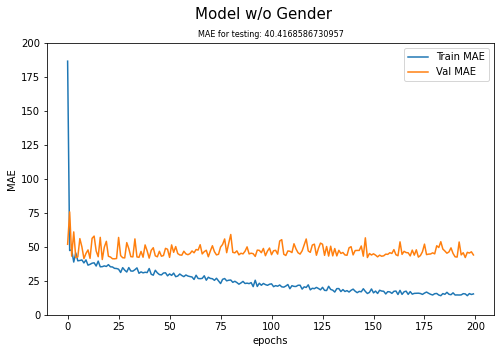

In [20]:
plt.figure(figsize=(8,5))
plt.plot(hist_wg.history['mean_absolute_error'])
plt.plot(hist_wg.history['val_mean_absolute_error'])
plt.gca().set_ylim([0, 200])
plt.xlabel("epochs")
plt.ylabel("MAE")
plt.legend(['Train MAE', 'Val MAE'])
plt.title(f"MAE for testing: {res_wg[0]}", size=8)
plt.suptitle("Model w/o Gender", size=15)
plt.show()

### Fitting With Gender

In [21]:
model_g = model_build(cnn_layer, gender=True)
model_g.summary()
model_g.compile(loss='mean_absolute_error', metrics=[MeanAbsoluteError()])

(1601,)
Model: "gender-based-model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1601)]            0         
                                                                 
 dense_3 (Dense)             (None, 2048)              3280896   
                                                                 
 dense_4 (Dense)             (None, 2048)              4196352   
                                                                 
 dense_5 (Dense)             (None, 1)                 2049      
                                                                 
Total params: 7,479,297
Trainable params: 7,479,297
Non-trainable params: 0
_________________________________________________________________


In [22]:
hist_g = model_g.fit(
    X_new_train_vectors,
    Y_train_vectors,
    epochs=200, 
    validation_data=(X_new_validation_vectors, Y_validation_vectors)
)

Epoch 1/200
11/11 [==============================] - 3s 162ms/step - loss: 186.3989 - mean_absolute_error: 185.5788 - val_loss: 40.0505 - val_mean_absolute_error: 41.8312
Epoch 2/200
11/11 [==============================] - 1s 134ms/step - loss: 48.1608 - mean_absolute_error: 48.1150 - val_loss: 40.1015 - val_mean_absolute_error: 45.5802
Epoch 3/200
11/11 [==============================] - 2s 144ms/step - loss: 43.5019 - mean_absolute_error: 43.5465 - val_loss: 66.1513 - val_mean_absolute_error: 77.8995
Epoch 4/200
11/11 [==============================] - 2s 162ms/step - loss: 46.2959 - mean_absolute_error: 46.2213 - val_loss: 41.1929 - val_mean_absolute_error: 41.4964
Epoch 5/200
11/11 [==============================] - 2s 176ms/step - loss: 41.6886 - mean_absolute_error: 41.6667 - val_loss: 38.5836 - val_mean_absolute_error: 44.6577
Epoch 6/200
11/11 [==============================] - 2s 140ms/step - loss: 37.8780 - mean_absolute_error: 37.8539 - val_loss: 78.2044 - val_mean_absolute

11/11 [==============================] - 2s 146ms/step - loss: 29.6792 - mean_absolute_error: 29.6525 - val_loss: 42.0391 - val_mean_absolute_error: 47.9710
Epoch 50/200
11/11 [==============================] - 2s 138ms/step - loss: 30.6572 - mean_absolute_error: 30.6062 - val_loss: 43.5386 - val_mean_absolute_error: 43.7103
Epoch 51/200
11/11 [==============================] - 1s 133ms/step - loss: 29.2852 - mean_absolute_error: 29.2816 - val_loss: 41.1913 - val_mean_absolute_error: 48.4998
Epoch 52/200
11/11 [==============================] - 1s 134ms/step - loss: 30.5848 - mean_absolute_error: 30.5591 - val_loss: 41.1855 - val_mean_absolute_error: 46.3524
Epoch 53/200
11/11 [==============================] - 2s 140ms/step - loss: 27.8997 - mean_absolute_error: 27.9055 - val_loss: 45.4914 - val_mean_absolute_error: 53.0872
Epoch 54/200
11/11 [==============================] - 1s 134ms/step - loss: 29.8889 - mean_absolute_error: 29.8654 - val_loss: 40.5826 - val_mean_absolute_error: 4

11/11 [==============================] - 2s 177ms/step - loss: 21.3309 - mean_absolute_error: 21.3744 - val_loss: 40.2992 - val_mean_absolute_error: 43.1649
Epoch 98/200
11/11 [==============================] - 2s 148ms/step - loss: 21.1380 - mean_absolute_error: 21.1259 - val_loss: 40.1190 - val_mean_absolute_error: 42.5802
Epoch 99/200
11/11 [==============================] - 2s 145ms/step - loss: 21.7865 - mean_absolute_error: 21.7782 - val_loss: 40.4606 - val_mean_absolute_error: 45.8312
Epoch 100/200
11/11 [==============================] - 2s 147ms/step - loss: 20.7694 - mean_absolute_error: 20.7508 - val_loss: 43.5588 - val_mean_absolute_error: 47.5510
Epoch 101/200
11/11 [==============================] - 2s 145ms/step - loss: 23.6219 - mean_absolute_error: 23.6486 - val_loss: 42.0768 - val_mean_absolute_error: 44.7971
Epoch 102/200
11/11 [==============================] - 2s 144ms/step - loss: 20.7982 - mean_absolute_error: 20.7855 - val_loss: 41.3028 - val_mean_absolute_error

11/11 [==============================] - 2s 163ms/step - loss: 16.8641 - mean_absolute_error: 16.8493 - val_loss: 42.4872 - val_mean_absolute_error: 42.3293
Epoch 146/200
11/11 [==============================] - 2s 159ms/step - loss: 17.6221 - mean_absolute_error: 17.6743 - val_loss: 39.5772 - val_mean_absolute_error: 41.3868
Epoch 147/200
11/11 [==============================] - 2s 138ms/step - loss: 15.7433 - mean_absolute_error: 15.7374 - val_loss: 41.9193 - val_mean_absolute_error: 47.8160
Epoch 148/200
11/11 [==============================] - 2s 137ms/step - loss: 16.8279 - mean_absolute_error: 16.8026 - val_loss: 43.2957 - val_mean_absolute_error: 42.1193
Epoch 149/200
11/11 [==============================] - 2s 143ms/step - loss: 17.9866 - mean_absolute_error: 18.0105 - val_loss: 39.2726 - val_mean_absolute_error: 42.1662
Epoch 150/200
11/11 [==============================] - 2s 167ms/step - loss: 16.7011 - mean_absolute_error: 16.6898 - val_loss: 43.7050 - val_mean_absolute_err

Epoch 193/200
11/11 [==============================] - 2s 150ms/step - loss: 13.9344 - mean_absolute_error: 13.9314 - val_loss: 44.5092 - val_mean_absolute_error: 41.6957
Epoch 194/200
11/11 [==============================] - 2s 161ms/step - loss: 15.4232 - mean_absolute_error: 15.4115 - val_loss: 45.3111 - val_mean_absolute_error: 50.7197
Epoch 195/200
11/11 [==============================] - 2s 156ms/step - loss: 16.1285 - mean_absolute_error: 16.1235 - val_loss: 43.9229 - val_mean_absolute_error: 44.0529
Epoch 196/200
11/11 [==============================] - 2s 157ms/step - loss: 14.8166 - mean_absolute_error: 14.8071 - val_loss: 40.0550 - val_mean_absolute_error: 43.6621
Epoch 197/200
11/11 [==============================] - 2s 163ms/step - loss: 14.5348 - mean_absolute_error: 14.5253 - val_loss: 44.9371 - val_mean_absolute_error: 45.3822
Epoch 198/200
11/11 [==============================] - 2s 177ms/step - loss: 14.9403 - mean_absolute_error: 14.9302 - val_loss: 41.1753 - val_mea

In [23]:
res_g = model_g.evaluate(X_new_test_vectors, Y_test_vectors)
res_g

2/2 [==============================] - 0s 28ms/step - loss: 37.2069 - mean_absolute_error: 37.5139


[37.206886291503906, 37.51392364501953]

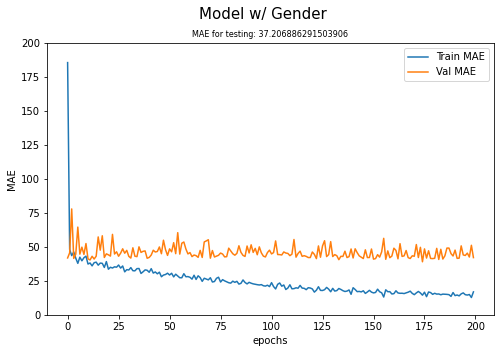

In [24]:
plt.figure(figsize=(8,5))
plt.plot(hist_g.history['mean_absolute_error'])
plt.plot(hist_g.history['val_mean_absolute_error'])
plt.gca().set_ylim([0, 200])
plt.xlabel("epochs")
plt.ylabel("MAE")
plt.legend(['Train MAE', 'Val MAE'])
plt.title(f"MAE for testing: {res_g[0]}", size=8)
plt.suptitle("Model w/ Gender", size=15)
plt.show()

# Feature Extraction Visualization
- https://stackoverflow.com/questions/9638826/plot-a-black-and-white-binary-map-in-matplotlib
- https://stackoverflow.com/questions/37971541/how-does-the-indexing-of-subplots-work
- https://stackoverflow.com/questions/18266642/multiple-imshow-subplots-each-with-colorbar
- https://www.analyticsvidhya.com/blog/2020/11/tutorial-how-to-visualize-feature-maps-directly-from-cnn-layers/
- https://stackoverflow.com/questions/59930781/how-to-extract-features-from-an-image-for-training-a-cnn-model
- https://medium.com/bisa-ai/feature-map-pada-convolutional-neural-network-cnn-e3c000e914a

In [ ]:
model = load_model('model/model_medium_150_epochs.h5', compile=False)

### Layer 1

In [284]:
model_feature = Model(inputs=model.inputs, outputs=model.layers[0].output)
model_feature.summary()

Model: "model_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_64_input (InputLayer  [(None, 224, 224, 3)]    0         
 )                                                               
                                                                 
 conv2d_64 (Conv2D)          (None, 222, 222, 128)     3584      
                                                                 
Total params: 3,584
Trainable params: 3,584
Non-trainable params: 0
_________________________________________________________________


In [285]:
feature_map = model_feature.predict(test_generator)

In [286]:
feature_map.shape

(20, 222, 222, 128)

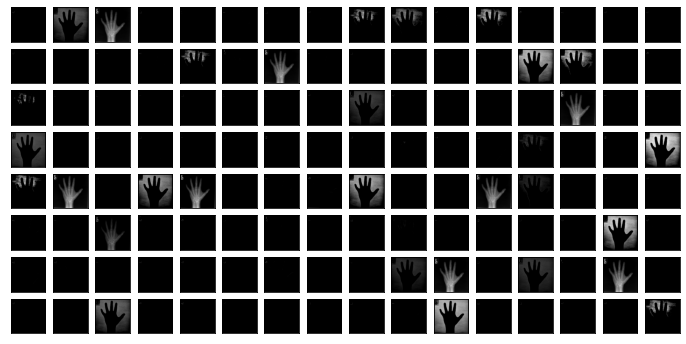

In [287]:
size_x = 8
size_y = 16
index = 1
plt.figure(figsize=(12, 6))

for _ in range(size_x):
    for _ in range(size_y):
        axs = plt.subplot(size_x,size_y,index)
        axs.set_xticks([])
        axs.set_yticks([])
    
        plt.imshow(feature_map[0,:,:,index-1], cmap='gray')
        index = index + 1
plt.show()

### Layer 2

In [282]:
model_feature = Model(inputs=model.inputs, outputs=model.layers[1].output)
model_feature.summary()

feature_map = model_feature.predict(test_generator)
print(feature_map.shape)

Model: "model_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_64_input (InputLayer  [(None, 224, 224, 3)]    0         
 )                                                               
                                                                 
 conv2d_64 (Conv2D)          (None, 222, 222, 128)     3584      
                                                                 
 max_pooling2d_60 (MaxPoolin  (None, 111, 111, 128)    0         
 g2D)                                                            
                                                                 
Total params: 3,584
Trainable params: 3,584
Non-trainable params: 0
_________________________________________________________________
(20, 111, 111, 128)


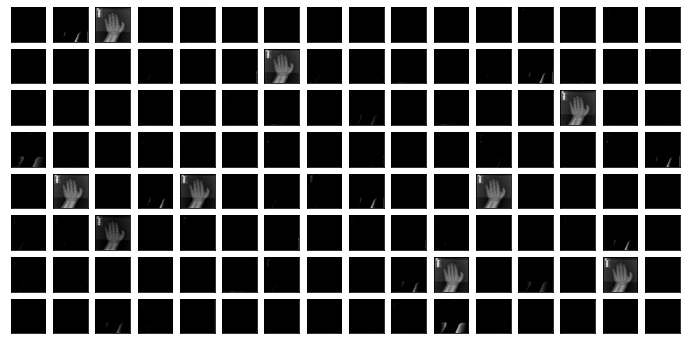

In [283]:
size_x = 8
size_y = 16
index = 1
plt.figure(figsize=(12, 6))

for _ in range(size_x):
    for _ in range(size_y):
        axs = plt.subplot(size_x,size_y,index)
        axs.set_xticks([])
        axs.set_yticks([])
    
        plt.imshow(feature_map[0,:,:,index-1], cmap='gray')
        index = index + 1
plt.show()

### Layer 3

In [254]:
model_feature = Model(inputs=model.inputs, outputs=model.layers[2].output)
model_feature.summary()

feature_map = model_feature.predict(test_generator)
print(feature_map.shape)

Model: "model_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_64_input (InputLayer  [(None, 224, 224, 3)]    0         
 )                                                               
                                                                 
 conv2d_64 (Conv2D)          (None, 222, 222, 128)     3584      
                                                                 
 max_pooling2d_60 (MaxPoolin  (None, 111, 111, 128)    0         
 g2D)                                                            
                                                                 
 conv2d_65 (Conv2D)          (None, 109, 109, 256)     295168    
                                                                 
Total params: 298,752
Trainable params: 298,752
Non-trainable params: 0
_________________________________________________________________
(20, 109, 109, 256)


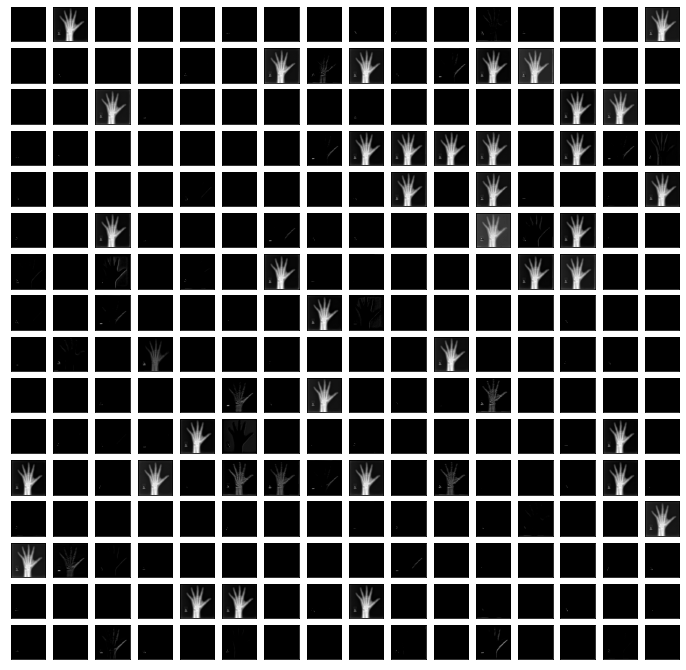

In [255]:
size = 16 # 256 channels displayed
index = 1
plt.figure(figsize=(12, 12))

for _ in range(size):
    for _ in range(size):
        axs = plt.subplot(size,size,index)
        axs.set_xticks([])
        axs.set_yticks([])
    
        plt.imshow(feature_map[0,:,:,index-1], cmap='gray')
        index = index + 1
plt.show()

### Layer 4

In [256]:
model_feature = Model(inputs=model.inputs, outputs=model.layers[3].output)
model_feature.summary()

feature_map = model_feature.predict(test_generator)
print(feature_map.shape)

Model: "model_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_64_input (InputLayer  [(None, 224, 224, 3)]    0         
 )                                                               
                                                                 
 conv2d_64 (Conv2D)          (None, 222, 222, 128)     3584      
                                                                 
 max_pooling2d_60 (MaxPoolin  (None, 111, 111, 128)    0         
 g2D)                                                            
                                                                 
 conv2d_65 (Conv2D)          (None, 109, 109, 256)     295168    
                                                                 
 max_pooling2d_61 (MaxPoolin  (None, 54, 54, 256)      0         
 g2D)                                                            
                                                          

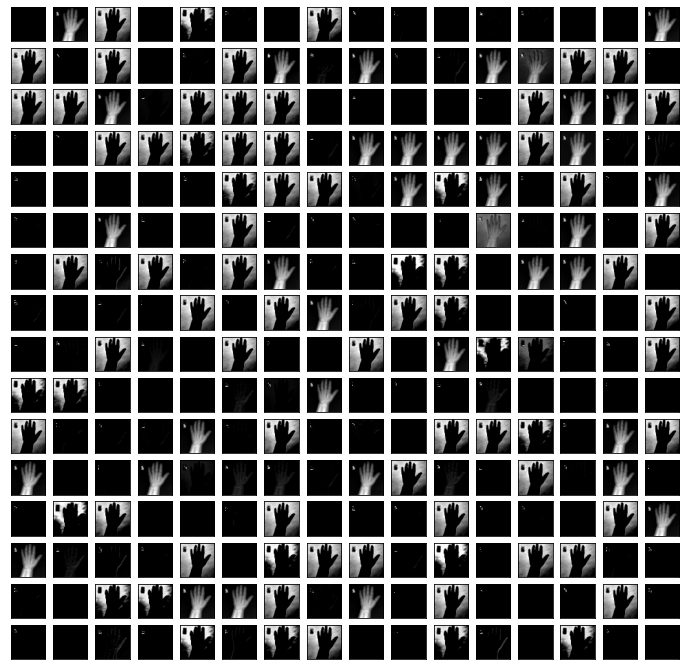

In [257]:
size = 16
index = 1
plt.figure(figsize=(12, 12))

for _ in range(size):
    for _ in range(size):
        axs = plt.subplot(size,size,index)
        axs.set_xticks([])
        axs.set_yticks([])
    
        plt.imshow(feature_map[0,:,:,index-1], cmap='gray')
        index = index + 1
plt.show()

### Layer 5

In [258]:
model_feature = Model(inputs=model.inputs, outputs=model.layers[4].output)
model_feature.summary()

feature_map = model_feature.predict(test_generator)
print(feature_map.shape)

Model: "model_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_64_input (InputLayer  [(None, 224, 224, 3)]    0         
 )                                                               
                                                                 
 conv2d_64 (Conv2D)          (None, 222, 222, 128)     3584      
                                                                 
 max_pooling2d_60 (MaxPoolin  (None, 111, 111, 128)    0         
 g2D)                                                            
                                                                 
 conv2d_65 (Conv2D)          (None, 109, 109, 256)     295168    
                                                                 
 max_pooling2d_61 (MaxPoolin  (None, 54, 54, 256)      0         
 g2D)                                                            
                                                          

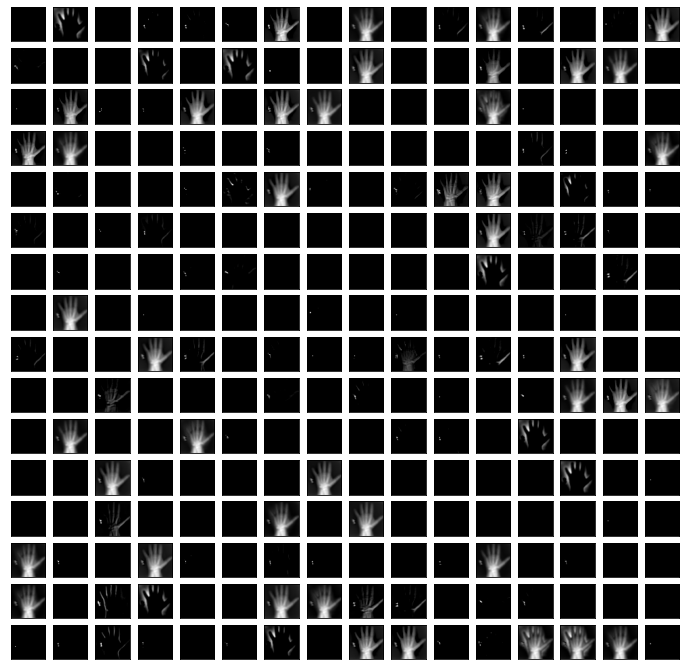

In [259]:
size = 16
index = 1
plt.figure(figsize=(12, 12))

for _ in range(size):
    for _ in range(size):
        axs = plt.subplot(size,size,index)
        axs.set_xticks([])
        axs.set_yticks([])
    
        plt.imshow(feature_map[0,:,:,index-1], cmap='gray')
        index = index + 1
plt.show()

### Layer 6

In [280]:
model_feature = Model(inputs=model.inputs, outputs=model.layers[5].output)
model_feature.summary()

feature_map = model_feature.predict(test_generator)
print(feature_map.shape)

Model: "model_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_64_input (InputLayer  [(None, 224, 224, 3)]    0         
 )                                                               
                                                                 
 conv2d_64 (Conv2D)          (None, 222, 222, 128)     3584      
                                                                 
 max_pooling2d_60 (MaxPoolin  (None, 111, 111, 128)    0         
 g2D)                                                            
                                                                 
 conv2d_65 (Conv2D)          (None, 109, 109, 256)     295168    
                                                                 
 max_pooling2d_61 (MaxPoolin  (None, 54, 54, 256)      0         
 g2D)                                                            
                                                          

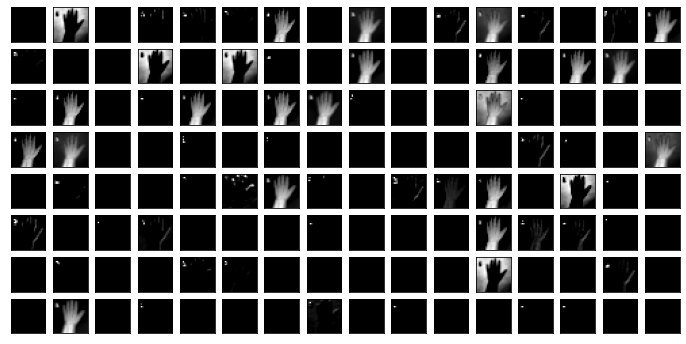

In [281]:
size_x = 8
size_y = 16
index = 1
plt.figure(figsize=(12, 6))

for _ in range(size_x):
    for _ in range(size_y):
        axs = plt.subplot(size_x,size_y,index)
        axs.set_xticks([])
        axs.set_yticks([])
    
        plt.imshow(feature_map[0,:,:,index-1], cmap='gray')
        index = index + 1
plt.show()

### Layer 7

In [278]:
model_feature = Model(inputs=model.inputs, outputs=model.layers[6].output)
model_feature.summary()

feature_map = model_feature.predict(test_generator)
print(feature_map.shape)

Model: "model_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_64_input (InputLayer  [(None, 224, 224, 3)]    0         
 )                                                               
                                                                 
 conv2d_64 (Conv2D)          (None, 222, 222, 128)     3584      
                                                                 
 max_pooling2d_60 (MaxPoolin  (None, 111, 111, 128)    0         
 g2D)                                                            
                                                                 
 conv2d_65 (Conv2D)          (None, 109, 109, 256)     295168    
                                                                 
 max_pooling2d_61 (MaxPoolin  (None, 54, 54, 256)      0         
 g2D)                                                            
                                                          

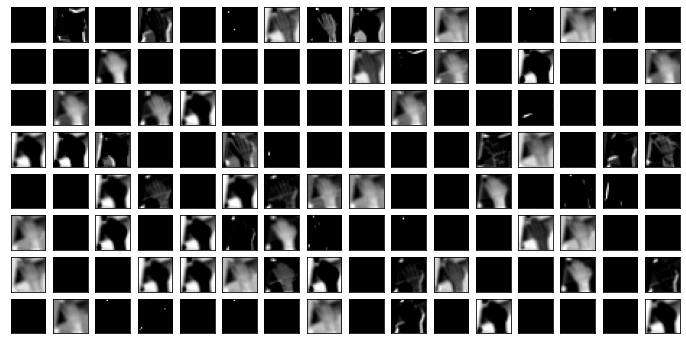

In [279]:
size_x = 8
size_y = 16
index = 1
plt.figure(figsize=(12, 6))

for _ in range(size_x):
    for _ in range(size_y):
        axs = plt.subplot(size_x,size_y,index)
        axs.set_xticks([])
        axs.set_yticks([])
    
        plt.imshow(feature_map[0,:,:,index-1], cmap='gray')
        index = index + 1
plt.show()

### Layer 8

In [275]:
model_feature = Model(inputs=model.inputs, outputs=model.layers[7].output)
model_feature.summary()

feature_map = model_feature.predict(test_generator)
print(feature_map.shape)

Model: "model_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_64_input (InputLayer  [(None, 224, 224, 3)]    0         
 )                                                               
                                                                 
 conv2d_64 (Conv2D)          (None, 222, 222, 128)     3584      
                                                                 
 max_pooling2d_60 (MaxPoolin  (None, 111, 111, 128)    0         
 g2D)                                                            
                                                                 
 conv2d_65 (Conv2D)          (None, 109, 109, 256)     295168    
                                                                 
 max_pooling2d_61 (MaxPoolin  (None, 54, 54, 256)      0         
 g2D)                                                            
                                                          

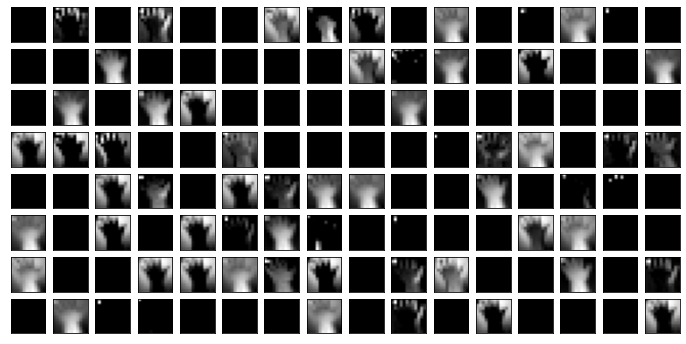

In [276]:
size_x = 8
size_y = 16
index = 1
plt.figure(figsize=(12, 6))

for _ in range(size_x):
    for _ in range(size_y):
        axs = plt.subplot(size_x,size_y,index)
        axs.set_xticks([])
        axs.set_yticks([])
    
        plt.imshow(feature_map[0,:,:,index-1], cmap='gray')
        index = index + 1
plt.show()

### Layer 9

In [266]:
model_feature = Model(inputs=model.inputs, outputs=model.layers[8].output)
model_feature.summary()

feature_map = model_feature.predict(test_generator)
print(feature_map.shape)

Model: "model_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_64_input (InputLayer  [(None, 224, 224, 3)]    0         
 )                                                               
                                                                 
 conv2d_64 (Conv2D)          (None, 222, 222, 128)     3584      
                                                                 
 max_pooling2d_60 (MaxPoolin  (None, 111, 111, 128)    0         
 g2D)                                                            
                                                                 
 conv2d_65 (Conv2D)          (None, 109, 109, 256)     295168    
                                                                 
 max_pooling2d_61 (MaxPoolin  (None, 54, 54, 256)      0         
 g2D)                                                            
                                                          

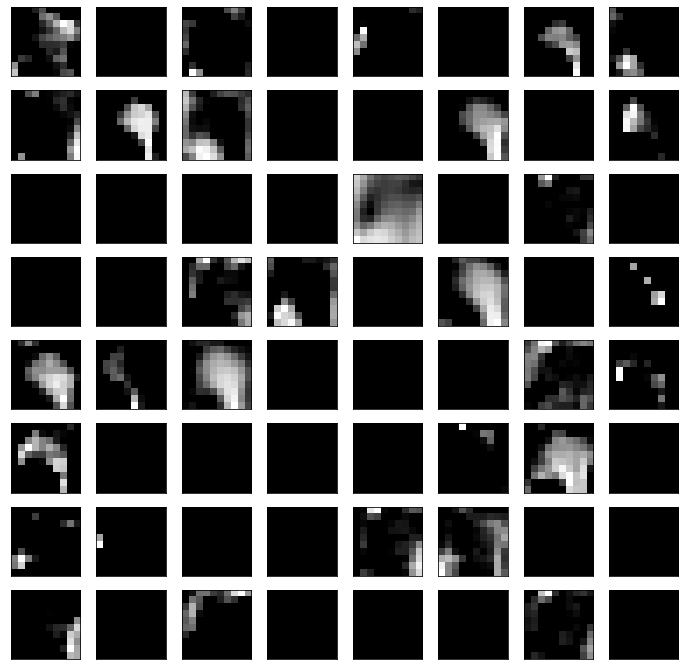

In [267]:
size_x = 8
size_y = 8
index = 1
plt.figure(figsize=(12, 12))

for _ in range(size_x):
    for _ in range(size_y):
        axs = plt.subplot(size_x,size_y,index)
        axs.set_xticks([])
        axs.set_yticks([])
    
        plt.imshow(feature_map[0,:,:,index-1], cmap='gray')
        index = index + 1
plt.show()

### Layer 10

In [268]:
model_feature = Model(inputs=model.inputs, outputs=model.layers[9].output)
model_feature.summary()

feature_map = model_feature.predict(test_generator)
print(feature_map.shape)

Model: "model_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_64_input (InputLayer  [(None, 224, 224, 3)]    0         
 )                                                               
                                                                 
 conv2d_64 (Conv2D)          (None, 222, 222, 128)     3584      
                                                                 
 max_pooling2d_60 (MaxPoolin  (None, 111, 111, 128)    0         
 g2D)                                                            
                                                                 
 conv2d_65 (Conv2D)          (None, 109, 109, 256)     295168    
                                                                 
 max_pooling2d_61 (MaxPoolin  (None, 54, 54, 256)      0         
 g2D)                                                            
                                                          

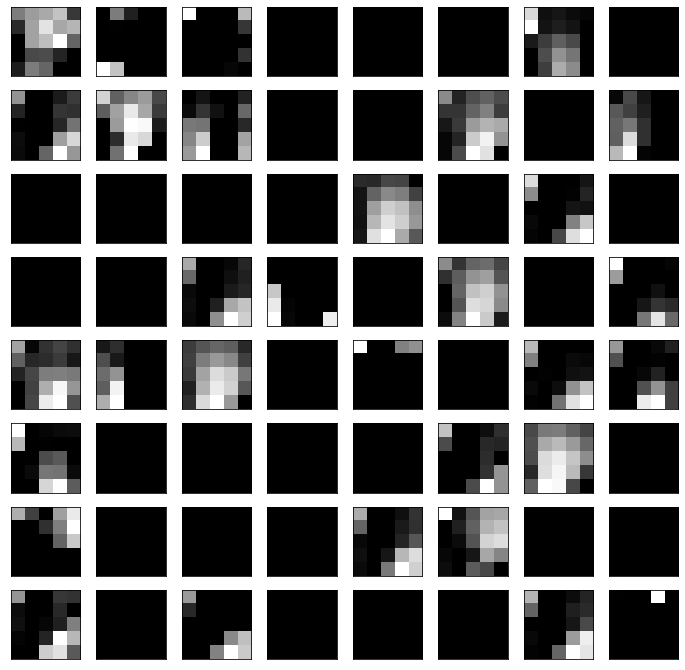

In [269]:
size_x = 8
size_y = 8
index = 1
plt.figure(figsize=(12, 12))

for _ in range(size_x):
    for _ in range(size_y):
        axs = plt.subplot(size_x,size_y,index)
        axs.set_xticks([])
        axs.set_yticks([])
    
        plt.imshow(feature_map[0,:,:,index-1], cmap='gray')
        index = index + 1
plt.show()